# Non-linear Matrix Factorization with Gaussian Processes

This is an attempt to reproduce [this ICML 2009 paper](http://people.ee.duke.edu/~lcarin/MatrixFactorization.pdf).

In [126]:
import tensorflow as tf
DEVICE = "/cpu:0"

In [127]:
N = 100  # items
D = 2071  # users
q = 10  # latent dimension

In [128]:
# Simulated data
import numpy as np
from sklearn.preprocessing import scale

def get_simulated_data(true_alpha_x=5, true_alpha_w=2, true_sigma=1):
    X = np.random.randint(50, size=(N, q))
    #X = np.random.normal(0, 1/true_alpha_x, (N, q))
    W = np.random.normal(0, 1/true_alpha_w, (D, q))
    rating_rows = []
    for i in range(N):
        rating_rows.append(np.random.multivariate_normal(W.dot(X[i, :]), true_sigma ** 2 * np.eye(D)))
    Y = np.array(rating_rows)
    Y_scaled = scale(Y, axis=1, with_std=False)
    return Y, Y_scaled

In [129]:
# Real data
from mangaki.algo.dataset import Dataset
from mangaki.utils.values import rating_values

dataset = Dataset()
dataset.load_csv('ratings-ordered.csv', convert=lambda choice: rating_values[choice])

In [130]:
from scipy.sparse import coo_matrix

rows = dataset.anonymized.X[:, 0]
cols = dataset.anonymized.X[:, 1]
data = dataset.anonymized.y
mangaki = coo_matrix((data, (rows, cols)), shape=(dataset.anonymized.nb_users, dataset.anonymized.nb_works)).tocsr()

In [131]:
mangaki

<2071x10086 sparse matrix of type '<class 'numpy.float64'>'
	with 333647 stored elements in Compressed Sparse Row format>

In [132]:
mangaki[:, :100]

<2071x100 sparse matrix of type '<class 'numpy.float64'>'
	with 78195 stored elements in Compressed Sparse Row format>

In [133]:
Y = mangaki[:, :100].tocoo().T.tocsr()
for movie_id in range(N):
    row = Y[movie_id, :]
    for user_id, replace in zip(row.indices, scale(row.data)):
        Y[movie_id, user_id] = replace

In [134]:
dataset = coo_matrix(Y)
#dataset = coo_matrix(Y_scaled)

In [135]:
Y

<100x2071 sparse matrix of type '<class 'numpy.float64'>'
	with 78195 stored elements in Compressed Sparse Row format>

In [136]:
# Prepare batches
from sklearn.model_selection import ShuffleSplit

# Simple split
splitter = ShuffleSplit(n_splits=1, test_size=0.2)
for i_train, i_test in splitter.split(dataset.data):
    train = coo_matrix((dataset.data[i_train], (dataset.row[i_train], dataset.col[i_train])), shape=(N, D)).tocsc()
    test = coo_matrix((dataset.data[i_test], (dataset.row[i_test], dataset.col[i_test])), shape=(N, D)).tocsc()

# Split by user
train_data = []
train_row = []
train_col = []
test_data = []
test_row = []
test_col = []
full = dataset.tocsc()
nb_skip = 0
train_users = set(range(D))
for user_id in range(D):
    this_user = full[:, user_id]
    N_j = this_user.getnnz()
    if N_j <= q:
        train_users.remove(user_id)
        nb_skip += 1
        continue
    for i_train, i_test in splitter.split(this_user.indices):
        train_col.extend([user_id] * len(i_train))
        train_row.extend(this_user.indices[i_train])
        train_data.extend(this_user.data[i_train])
        test_col.extend([user_id] * len(i_test))
        test_row.extend(this_user.indices[i_test])
        test_data.extend(this_user.data[i_test])
print('nb users skipped', nb_skip, 'over', D)

nb users skipped 465 over 2071


In [137]:
assert len(train_data) == len(train_row)
assert len(test_data) == len(test_row)

In [138]:
train = coo_matrix((train_data, (train_row, train_col)), shape=(N, D)).tocsc()
test = coo_matrix((test_data, (test_row, test_col)), shape=(N, D)).tocsc()

In [139]:
train

<100x2071 sparse matrix of type '<class 'numpy.float64'>'
	with 60093 stored elements in Compressed Sparse Column format>

In [140]:
test

<100x2071 sparse matrix of type '<class 'numpy.float64'>'
	with 15842 stored elements in Compressed Sparse Column format>

In [141]:
item_batch = tf.placeholder(tf.int32, shape=[None], name="id_item")
rate_batch = tf.placeholder(tf.float32, shape=[None, None], name="rate")
pred_batch = tf.placeholder(tf.int32, shape=[None], name="id_pred")

In [142]:
def log_det(cov):
    return 2 * tf.reduce_sum(tf.log(tf.diag_part(tf.cholesky(cov))))

In [146]:
def kernel(X, Y):
    return tf.matmul(X, tf.transpose(Y))

class MFGP:
    def __init__(self):
        with tf.device(DEVICE):
            with tf.variable_scope("conv1"):
                self.sigma = tf.Variable(1e-1, name="sigma")  # tf.random_normal([1])
                self.alpha_w = tf.Variable(tf.random_normal([1]), name="alpha_w")
                self.X_item = tf.Variable(tf.random_normal([N, q], stddev=5), name="embd_item")

    def predict(self, item_batch, rate_batch, pred_batch):
        with tf.device(DEVICE):
            X_batch = tf.nn.embedding_lookup(self.X_item, item_batch)
            X_pred = tf.nn.embedding_lookup(self.X_item, pred_batch)
            N_j = tf.shape(item_batch)[0]
            cov = kernel(X_batch, X_batch) + self.sigma ** 2 * tf.eye(N_j)
            s = tf.matmul(tf.matrix_inverse(cov), kernel(X_batch, X_pred))
            prediction = tf.matmul(tf.transpose(s), rate_batch)
        return tf.reshape(prediction, [-1])

    def get_loss(self, item_batch, rate_batch):
        with tf.device(DEVICE):
            X_batch = tf.nn.embedding_lookup(self.X_item, item_batch)
            XT_batch = tf.transpose(X_batch)
            N_j = tf.shape(item_batch)[0]
            defpos = kernel(X_batch, X_batch)
            cov = 1/tf.abs(self.alpha_w) * defpos + self.sigma ** 2 * tf.eye(N_j)
            # inv_cov = tf.matrix_inverse(cov)  # O(N_j^3)
            cheap_inv = tf.matrix_inverse(tf.abs(self.alpha_w) * self.sigma ** (-2) * tf.eye(q)
                                          + tf.matmul(XT_batch, X_batch))
            inv_cov = self.sigma ** (-2) - self.sigma ** (-4) * tf.matmul(X_batch, tf.matmul(cheap_inv, XT_batch))  # O(q^3)
            loss = (tf.cast(N_j, tf.float32) * log_det(cov)
                    + tf.reshape(tf.matmul(tf.transpose(rate_batch), tf.matmul(inv_cov, rate_batch)), []))
        return loss, (cov, defpos, X_batch)

    def optimization(self, item_batch, rate_batch, learning_rate):
        global_step = tf.train.get_global_step()
        assert global_step is not None
        with tf.device(DEVICE):
            loss, (cov, defpos, X_batch) = self.get_loss(item_batch, rate_batch)
            train_op = tf.train.MomentumOptimizer(learning_rate, 0.9, use_nesterov=True).minimize(loss, global_step=global_step, var_list=[self.X_item])
        return loss, train_op, (cov, defpos, X_batch)

In [147]:
def to_matrix(l):
    return np.array(l).reshape(len(l), 1)

In [148]:
from sklearn.metrics import mean_squared_error
from collections import deque
import time
import random
import sys

mfgp = MFGP()
prediction = mfgp.predict(item_batch, rate_batch, pred_batch)

global_step = tf.contrib.framework.get_or_create_global_step()
loss, train_op, (cov, defpos, X_batch) = mfgp.optimization(item_batch, rate_batch, learning_rate=0.0001)

init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    print(" | ".join(["user_id", "epoch", "train_error", "val_error", "elapsed_time"]))
    errors = []
    for epoch in range(50):
        cross = list(train_users)
        random.shuffle(cross)
        train_preds = []
        train_ratings = []
        for user_id in cross:
            train_batch = train[:, user_id]
            if train_batch.getnnz() == 0:
                continue
            items_rated, ratings = train_batch.indices, to_matrix(train_batch.data)
            try:
                sess.run(train_op, feed_dict={item_batch: items_rated,
                                              rate_batch: ratings,
                                              pred_batch: items_rated})
            except Exception as e:
                print('Error for %d (%s): %s' % (user_id, str(items_rated), sys.exc_info()[0]))
                print('Sigma', mfgp.sigma.eval(), 'alpha_w', mfgp.alpha_w.eval())
                print(sess.run([tf.shape(X_batch), X_batch], feed_dict={item_batch: items_rated, rate_batch: ratings, pred_batch: items_rated}))
                print(sess.run(tf.matrix_determinant(defpos), feed_dict={item_batch: items_rated, rate_batch: ratings, pred_batch: items_rated}))
                print(sess.run(tf.matrix_determinant(cov), feed_dict={item_batch: items_rated, rate_batch: ratings, pred_batch: items_rated}))
                print(e.message)
                print(sys.exc_info()[0].__doc__)

        # End of train epoch, start test
        if epoch % 1 == 0:
            total_nll = []
            test_truth = []
            test_preds = []
            for user_id in train_users:
                train_batch = train[:, user_id]
                test_batch = test[:, user_id]
                items_rated, ratings = train_batch.indices, to_matrix(train_batch.data)
                items_to_pred, truth = test_batch.indices, test_batch.data
                try:
                    this_user_nll, train_pred = sess.run([loss, prediction], feed_dict={item_batch: items_rated,
                                                                                        rate_batch: ratings,
                                                                                        pred_batch: items_rated})
                except:
                    print('Error for train %d (%s): %s' % (user_id, str(items_rated), sys.exc_info()[0]))
                try:
                    test_pred = sess.run(prediction, feed_dict={item_batch: items_rated,
                                                                rate_batch: ratings,
                                                                pred_batch: items_to_pred})
                except:
                    print('Error for test %d (%s): %s' % (user_id, str(items_to_pred), sys.exc_info()[0]))
                total_nll.append(this_user_nll)
                train_ratings.extend(ratings)
                train_preds.extend(train_pred)
                test_truth.extend(truth)
                test_preds.extend(test_pred)
            train_rmse = np.sqrt(mean_squared_error(train_ratings, train_preds))            
            train_stupid = np.sqrt(mean_squared_error(train_ratings, [0] * len(train_ratings)))            
            test_rmse = np.sqrt(mean_squared_error(test_truth, test_preds))
            test_stupid = np.sqrt(mean_squared_error(test_truth, [0] * len(test_truth)))
            print("epoch={:3d} train_rmse={:f} ({:f}) test_rmse={:f} ({:f}) total_nll={:f} sigma={:f} alpha_w={:f}"
                  .format(epoch, train_rmse, train_stupid, test_rmse, test_stupid,
                          sum(total_nll), abs(float(mfgp.sigma.eval())), abs(float(mfgp.alpha_w.eval()))))
    print('learned sigma')
    print(mfgp.sigma.eval())
    print('learned alpha_w')
    print(mfgp.alpha_w.eval())
    print('learned x')
    print(mfgp.x_item.eval())

user_id | epoch | train_error | val_error | elapsed_time
epoch=  0 train_rmse=7.099235 (1.000710) test_rmse=6.157351 (1.003259) total_nll=-287224265.353516 sigma=0.100000 alpha_w=1.753959
epoch=  1 train_rmse=2.079178 (1.000710) test_rmse=2.118881 (1.003259) total_nll=-298726846.699219 sigma=0.100000 alpha_w=1.753959
epoch=  2 train_rmse=11.680286 (1.000710) test_rmse=9.852969 (1.003259) total_nll=-302750440.118164 sigma=0.100000 alpha_w=1.753959
epoch=  3 train_rmse=19.395447 (1.000710) test_rmse=15.919051 (1.003259) total_nll=-304895133.985352 sigma=0.100000 alpha_w=1.753959
epoch=  4 train_rmse=27.530071 (1.000710) test_rmse=28.348537 (1.003259) total_nll=-306099596.312500 sigma=0.100000 alpha_w=1.753959
epoch=  5 train_rmse=9.603479 (1.000710) test_rmse=9.229228 (1.003259) total_nll=-307085520.960938 sigma=0.100000 alpha_w=1.753959


KeyboardInterrupt: 

(The error is because it was interrupted.)

As you can see, the learning stops when the stupid RMSE (every prediction is 0) is obtained.

# Meanwhile, Alternating Least Squares…

In [7]:
from mangaki.algo.als import MangakiALS

als = MangakiALS()
als.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
als.fit(dataset.anonymized.X, dataset.anonymized.y)
y_pred = als.predict(dataset.anonymized.X)
als.compute_rmse(dataset.anonymized.y, y_pred)

Computing M: (2071 × 10086)
Chrono: fill and center matrix [0q, 853ms]
Shapes (2071, 20) (20, 10086)
Chrono: factor matrix [0q, 7092ms]


0.91994107245759782

And the learned rows of $U$ seem Gaussian!

(array([   1.,    7.,   42.,  205.,  567.,  853.,  290.,   79.,   20.,    7.]),
 array([ -1.38654935e+00,  -1.10934157e+00,  -8.32133779e-01,
         -5.54925992e-01,  -2.77718206e-01,  -5.10418758e-04,
          2.76697368e-01,   5.53905155e-01,   8.31112942e-01,
          1.10832073e+00,   1.38552852e+00]),
 <a list of 10 Patch objects>)

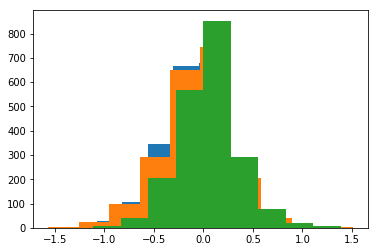

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(als.U[:, 0])
plt.hist(als.U[:, 1])
plt.hist(als.U[:, 15])

(array([  1.00000000e+00,   0.00000000e+00,   9.00000000e+00,
          8.40000000e+01,   7.04000000e+02,   3.09200000e+03,
          5.29100000e+03,   8.18000000e+02,   7.40000000e+01,
          1.30000000e+01]),
 array([-2.55654567, -2.15013171, -1.74371775, -1.33730379, -0.93088983,
        -0.52447587, -0.11806191,  0.28835205,  0.69476602,  1.10117998,
         1.50759394]),
 <a list of 10 Patch objects>)

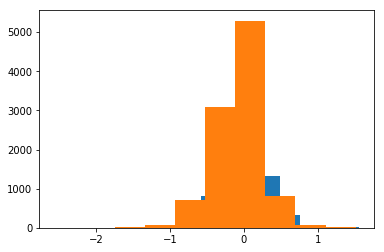

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(als.VT.T[:, 17])
plt.hist(als.VT.T[:, 5])

Maybe it does not hold for $V$.

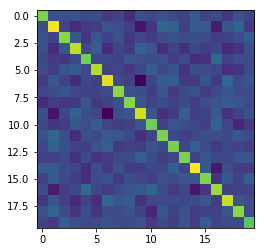

In [10]:
%matplotlib inline

cov = np.cov(als.U.T)
plt.imshow(cov)

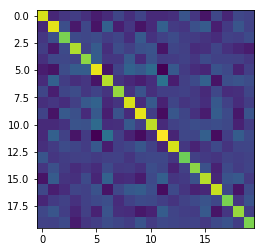

In [11]:
%matplotlib inline

cov = np.cov(als.VT)
plt.imshow(cov)

Learned components are independent.

In [23]:
PIG = 200
mangaki[PIG, :].indices
pig = mangaki[PIG, :]
#mangaki[PIG, :].data

In [63]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, Kernel

cov = np.cov(als.U.T)

In [73]:
class CovKernel(DotProduct):
    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X
        return X.dot(cov.dot(Y.T))

In [74]:
class DP(Kernel):
    """Dot-Product kernel.
    The DotProduct kernel is non-stationary and can be obtained from linear
    regression by putting N(0, 1) priors on the coefficients of x_d (d = 1, . .
    . , D) and a prior of N(0, \sigma_0^2) on the bias. The DotProduct kernel
    is invariant to a rotation of the coordinates about the origin, but not
    translations. It is parameterized by a parameter sigma_0^2. For
    sigma_0^2 =0, the kernel is called the homogeneous linear kernel, otherwise
    it is inhomogeneous. The kernel is given by
    k(x_i, x_j) = sigma_0 ^ 2 + x_i \cdot x_j
    The DotProduct kernel is commonly combined with exponentiation.
    .. versionadded:: 0.18
    Parameters
    ----------
    sigma_0 : float >= 0, default: 1.0
        Parameter controlling the inhomogenity of the kernel. If sigma_0=0,
        the kernel is homogenous.
    sigma_0_bounds : pair of floats >= 0, default: (1e-5, 1e5)
        The lower and upper bound on l
    """

    def __init__(self, sigma_0=1.0, sigma_0_bounds=(1e-5, 1e5)):
        self.sigma_0 = sigma_0
        self.sigma_0_bounds = sigma_0_bounds

    @property
    def hyperparameter_sigma_0(self):
        return Hyperparameter("sigma_0", "numeric", self.sigma_0_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):
        """Return the kernel k(X, Y) and optionally its gradient.
        Parameters
        ----------
        X : array, shape (n_samples_X, n_features)
            Left argument of the returned kernel k(X, Y)
        Y : array, shape (n_samples_Y, n_features), (optional, default=None)
            Right argument of the returned kernel k(X, Y). If None, k(X, X)
            if evaluated instead.
        eval_gradient : bool (optional, default=False)
            Determines whether the gradient with respect to the kernel
            hyperparameter is determined. Only supported when Y is None.
        Returns
        -------
        K : array, shape (n_samples_X, n_samples_Y)
            Kernel k(X, Y)
        K_gradient : array (opt.), shape (n_samples_X, n_samples_X, n_dims)
            The gradient of the kernel k(X, X) with respect to the
            hyperparameter of the kernel. Only returned when eval_gradient
            is True.
        """
        X = np.atleast_2d(X)
        if Y is None:
            K = np.inner(X, X) + self.sigma_0 ** 2
        else:
            if eval_gradient:
                raise ValueError(
                    "Gradient can only be evaluated when Y is None.")
            K = np.inner(X, Y) + self.sigma_0 ** 2

        if eval_gradient:
            if not self.hyperparameter_sigma_0.fixed:
                K_gradient = np.empty((K.shape[0], K.shape[1], 1))
                K_gradient[..., 0] = 2 * self.sigma_0 ** 2
                return K, K_gradient
            else:
                return K, np.empty((X.shape[0], X.shape[0], 0))
        else:
            return K

    def diag(self, X):
        """Returns the diagonal of the kernel k(X, X).
        The result of this method is identical to np.diag(self(X)); however,
        it can be evaluated more efficiently since only the diagonal is
        evaluated.
        Parameters
        ----------
        X : array, shape (n_samples_X, n_features)
            Left argument of the returned kernel k(X, Y)
        Returns
        -------
        K_diag : array, shape (n_samples_X,)
            Diagonal of kernel k(X, X)
        """
        return np.einsum('ij,ij->i', X, X) + self.sigma_0 ** 2

    def is_stationary(self):
        """Returns whether the kernel is stationary. """
        return False

    def __repr__(self):
        return "{0}(sigma_0={1:.3g})".format(
self.__class__.__name__, self.sigma_0)

40 rmse 1.70092636183
[ 2.22020149  2.68516827  4.221632    0.21681976  0.61815643] [ 2.   2.   4.   0.1  0.1]
80 rmse 1.34700663559
[ 2.3015213   2.47032928  3.53871918 -0.21498108  0.73708344] [ 2.   2.   4.   0.1  0.1]
120 rmse 1.19276073492
[ 2.19775391  2.26205444  3.22335052 -0.09634399  0.93307495] [ 2.   2.   4.   0.1  0.1]
160 rmse 1.16229773652
[ 1.6554718   2.10514069  3.34204483 -0.16519165  0.74554443] [ 2.   2.   4.   0.1  0.1]
200 rmse 1.12815781509
[ 1.42642212  1.95411682  3.37446594 -0.29171753  0.48626709] [ 2.   2.   4.   0.1  0.1]


/Users/jilljenn/code/mangaki/venv/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1174.12643433]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jilljenn/code/mangaki/venv/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 16187392.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


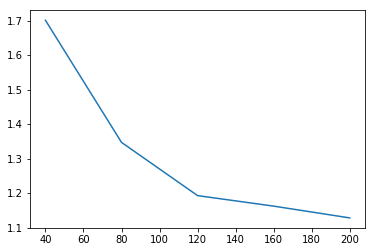

In [90]:
from sklearn.metrics import mean_squared_error

#kernel = CovKernel()
kernel = DotProduct()
gpr = GaussianProcessRegressor(kernel=kernel)
BATCH_SIZE = 40
steps = []
errors = []
for t in range(BATCH_SIZE, pig.getnnz() + 1, BATCH_SIZE):
    steps.append(t)
    work_ids = pig.indices[:t]
    ratings = pig.data[:t]
    gpr.fit(als.VT.T[work_ids], ratings)
    y_pred = gpr.predict(als.VT.T[pig.indices])
    rmse = mean_squared_error(pig.data, y_pred) ** 0.5
    errors.append(rmse)
    print(t, 'rmse', rmse)
    print(y_pred[:5], pig.data[:5])
plt.plot(steps, errors)

## Linear kernel

In [92]:
from mangaki.utils.dpp2 import MangakiDPP

rated = als.VT.T[pig.indices]
dpp = MangakiDPP(vectors=rated)
dpp.compute_similarity()
dpp.preprocess()

In [93]:
dpp.sample_k(5)

array([88, 12, 36,  5, 67])

5 random rmse 1.62222727598
[ 1.3007635   2.6198072   1.82325781  0.97224965  0.85570831] [ 2.   2.   4.   0.1  0.1]
5 dpp rmse 2.52267414821
[ 2.60496897  2.73953081  3.58007419  1.78849113  2.39674495] [ 2.   2.   4.   0.1  0.1]
10 random rmse 1.99122657248
[ 0.9770818   0.2174974   4.31546488  1.58601452  2.03113009] [ 2.   2.   4.   0.1  0.1]
10 dpp rmse 1.92255699023
[ 1.68276511  2.          3.79580797  0.32407584  0.77944718] [ 2.   2.   4.   0.1  0.1]
20 random rmse 4.22940473233
[-4.06521604 -6.58783135 -4.00747848 -6.50592412 -5.04052248] [ 2.   2.   4.   0.1  0.1]
20 dpp rmse 2.25918271205
[ 3.95991492  2.66094487  7.53086826 -0.52453134 -0.64353861] [ 2.   2.   4.   0.1  0.1]
50 random rmse 1.34040096374
[  2.10583210e-01   1.56891155e+00   3.49660873e+00  -1.28754425e+00
   1.50680542e-04] [ 2.   2.   4.   0.1  0.1]


/Users/jilljenn/code/mangaki/venv/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


50 dpp rmse 1.68529872053
[ 2.32190704  1.57808685  4.58464813  0.91820574  1.19605541] [ 2.   2.   4.   0.1  0.1]
100 random rmse 1.20425802451
[ 1.29516983  2.28824997  3.87503052 -0.92721128  0.04792404] [ 2.   2.   4.   0.1  0.1]
100 dpp rmse 1.22791956074
[ 1.81190932  2.06056023  3.45153046 -0.21545029  0.75030518] [ 2.   2.   4.   0.1  0.1]


/Users/jilljenn/code/mangaki/venv/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1280.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 80, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


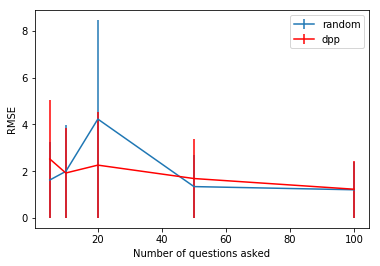

In [118]:
import random
from collections import defaultdict

kernel = DotProduct()
gpr = GaussianProcessRegressor(kernel=kernel)
BATCH_SIZE = 40
steps = []
errors = defaultdict(list)
errors_min = defaultdict(list)
errors_max = defaultdict(list)
total_rated = pig.getnnz()
for nb_rated in [5, 10, 20, 50, 100]:
    steps.append(nb_rated)
    for strategy in ['random', 'dpp']:
        if strategy == 'random':
            pos = random.sample(range(total_rated), nb_rated)
        else:
            pos = dpp.sample_k(nb_rated)
        work_ids = pig.indices[pos]
        ratings = pig.data[pos]
        
        gpr.fit(als.VT.T[work_ids], ratings)
        y_pred, sigma = gpr.predict(als.VT.T[pig.indices], return_std=True)
        rmse = mean_squared_error(pig.data, y_pred) ** 0.5
        rmse_max = mean_squared_error(pig.data, y_pred + 1.96 * sigma) ** 0.5
        rmse_min = mean_squared_error(pig.data, y_pred - 1.96 * sigma) ** 0.5
        errors[strategy].append(rmse)
        errors_max[strategy].append(rmse)
        errors_min[strategy].append(rmse)
        print(nb_rated, strategy, 'rmse', rmse)
        print(y_pred[:5], pig.data[:5])
rand_curve = plt.errorbar(steps, errors['random'], yerr=[errors_min['random'], errors_max['random']], label='random')
dpp_curve = plt.errorbar(steps, errors['dpp'], yerr=[errors_min['dpp'], errors_max['dpp']], color='r', label='dpp')
plt.legend(handles=[rand_curve, dpp_curve])
plt.xlabel('Number of questions asked')
plt.ylabel('RMSE')
plt.show()

## RBF kernel

In [119]:
from sklearn.gaussian_process.kernels import RBF

In [120]:
rated = als.VT.T[pig.indices]
rbf = RBF()
dpprbf = MangakiDPP(vectors=rated)
dpprbf.L = rbf(dpprbf.vectors)
dpprbf.preprocess()

5 random rmse 1.79613332935
[ 0.04473189 -0.03301084 -0.05597685  0.00632597 -0.03459759] [ 2.   2.   4.   0.1  0.1]
5 dpp rmse 1.82941215347
[-0.25862093 -0.16336525 -0.20274423 -0.18007164 -0.17123033] [ 2.   2.   4.   0.1  0.1]
10 random rmse 1.68034428766
[ 1.33240232  1.07421786  0.53673361  0.28625221  0.49504833] [ 2.   2.   4.   0.1  0.1]
10 dpp rmse 1.63266422001
[ 0.15704325  0.10822378 -0.04860578 -0.09830462 -0.08324711] [ 2.   2.   4.   0.1  0.1]
20 random rmse 1.59506961013
[ 0.25421302  0.17570141  0.16835161 -0.1749458  -0.06537943] [ 2.   2.   4.   0.1  0.1]
20 dpp rmse 1.4261763339
[ 0.65189646  1.65441879  0.76321672  0.17666345  0.27995731] [ 2.   2.   4.   0.1  0.1]
50 random rmse 1.27249791094
[ 0.14875917  2.          4.         -0.41027681 -0.2232384 ] [ 2.   2.   4.   0.1  0.1]
50 dpp rmse 1.13391318608
[ 1.4561379   2.          3.02989349  0.35886927  0.96010565] [ 2.   2.   4.   0.1  0.1]
100 random rmse 0.932778334269
[ 2.          2.          4.          0.

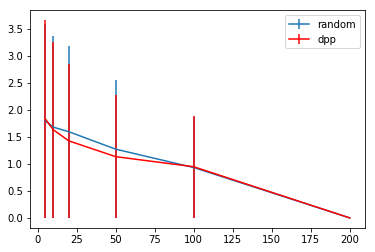

In [122]:
import random
from collections import defaultdict

kernel = DotProduct()
gpr = GaussianProcessRegressor()
BATCH_SIZE = 40
steps = []
errors = defaultdict(list)
errors_min = defaultdict(list)
errors_max = defaultdict(list)
total_rated = pig.getnnz()
for nb_rated in [5, 10, 20, 50, 100, 200]:
    steps.append(nb_rated)
    for strategy in ['random', 'dpp']:
        if strategy == 'random':
            pos = random.sample(range(total_rated), nb_rated)
        else:
            pos = dpprbf.sample_k(nb_rated)
        work_ids = pig.indices[pos]
        ratings = pig.data[pos]
        
        gpr.fit(als.VT.T[work_ids], ratings)
        y_pred, sigma = gpr.predict(als.VT.T[pig.indices], return_std=True)
        rmse = mean_squared_error(pig.data, y_pred) ** 0.5
        rmse_max = mean_squared_error(pig.data, y_pred + 1.96 * sigma) ** 0.5
        rmse_min = mean_squared_error(pig.data, y_pred - 1.96 * sigma) ** 0.5
        errors[strategy].append(rmse)
        errors_max[strategy].append(rmse)
        errors_min[strategy].append(rmse)
        print(nb_rated, strategy, 'rmse', rmse)
        print(y_pred[:5], pig.data[:5])
rand_curve = plt.errorbar(steps, errors['random'], yerr=[errors_min['random'], errors_max['random']], label='random')
dpp_curve = plt.errorbar(steps, errors['dpp'], yerr=[errors_min['dpp'], errors_max['dpp']], color='r', label='dpp')
plt.legend(handles=[rand_curve, dpp_curve])
plt.show()